
$$ \Large \underline{SD-TSIA211: \space Optimization \space For \space Machine \space Learning} $$

<h1><center> Computer Lab 1 : Natural Language Processing</center></h1>

<br>

<h2>             Done by : </h2>

<h2><center>Dardare Clement</center></h2>





<br>

<br>

In [1]:
import numpy as np
from tp_reglog_utils import load_data
from scipy.optimize import check_grad
import math
import warnings
warnings.simplefilter(action='ignore') # setting ignore as a parameter and further adding category
import matplotlib.pyplot as plt

### Importing data

In [3]:
X, y, X_test, y_test = load_data(file_name_matrix='tfidf_matrix.npz', file_name_feature_names='feature_names.npy',
	      file_name_labels='train_labels.npy', samples_in_train_set=200,
	      samples_in_test_set=137562)

### Question 3.1

$$f_1 : (w_0, w) \mapsto \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i(x_i^T w + w_0))) + \frac{\rho}{2} \|w\|_2^2$$
computing the gradient of f1 gives us : 
$$\nabla f_1((w_0, w)) = \begin{pmatrix} 
\frac{\partial f_{1}}{\partial w_{0}} \\ 
\frac{\partial f_{1}}{\partial w} 
 \end{pmatrix} =    \begin{bmatrix}
          \frac{1}{n} \sum_{i=1}^n \frac {exp(-y_i.(x^T_i \omega + \omega_0))}{1 + exp(-y_i.(x^T_i \omega + \omega_0))} (-y_i)   \\
          \frac{1}{n} \sum_{i=1}^n \frac {exp(-y_i.(x^T_i \omega + \omega_0))}{1 + exp(-y_i.(x^T_i \omega + \omega_0))} (-y_i x_i) + \rho . \omega   
         \end{bmatrix}
$$
let's calculate each term of the Hessian matrix:
$$\frac{\partial^2 f_1}{\partial \omega_{0}^2} = \frac{1}{n}\sum_{i=1}^{n}\frac{y_{i}^2.exp(-y_{i}.(x_{i}^{T}\omega+\omega _{0}))}{(1+exp(-y_{i}.(x_{i}^{T}\omega +\omega _{0})))^2}$$

$$\frac{\partial^2 f_1}{\partial \omega^2} = \frac{1}{n}\sum_{i=1}^{n}\frac{y_{i}^2.x_{i}.x_{i}^T.exp(-y_{i}.(x_{i}^{T}\omega+\omega _{0}))}{(1+exp(-y_{i}.(x_{i}^{T}\omega +\omega _{0})))^2} + \rho . I_p $$

$$\frac{\partial^2 f_1}{\partial \omega.\partial \omega_{0}} = \frac{1}{n}\sum_{i=1}^{n}\frac{y_{i}^{2}.x_{i}^T.exp(-y_{i}.(x_{i}^{T}\omega+\omega _{0}))}{(1+exp(-y_{i}.(x_{i}^{T}\omega +\omega _{0})))^2}$$

$$\frac{\partial^2 f_1}{\partial \omega_{0}.\partial \omega} = \frac{1}{n}\sum_{i=1}^{n}\frac{y_{i}^{2}.x_{i}^T.exp(-y_{i}.(x_{i}^{T}\omega+\omega _{0}))}{(1+exp(-y_{i}.(x_{i}^{T}\omega +\omega _{0})))^2}$$

We can write the resulting matrix like written below: 

$$ \frac{1}{n}\sum_{i=1}^{n}\frac{y_{i}^{2}.exp(-y_{i}.(x_{i}^{T}\omega+\omega _{0}))}{(1+exp(-y_{i}.(x_{i}^{T}\omega +\omega _{0})))^2}\begin{pmatrix}
1 &x_{i}^T \\ 
x_{i}^T &  x_{i}x_{i}^T
\end{pmatrix}
+ \rho \begin{pmatrix}
0&0 \\ 
0 &  I_{p}
\end{pmatrix}$$
$\space$

From this expression, we can notice that it's a positive definite matrix, by adding the first term which is semi-definite and positive to the second term with $ρ > 0$, we ensure that all of the eigenvalues of the matrix are strictly positive. We can conclude that $f_1$ is convex.


### Question 3.2

In [27]:
def Computing(w,w0,x,y,rho):
    n=x.shape[0]
#---------func
    f1=0
    i=0
    while i<n :
        f1+=np.log(1+np.exp(-y[i]*(np.dot(x[i],w)+w0)))
        i=i+1
    f1*=(1/x.shape[0])
    f1 += rho/2 * np.linalg.norm(w)**2
#-------------grad
    fw0=0
    fw=0 
    i=0
    while i<X.shape[0]:
        S=(1+np.exp(-y[i]*(np.dot(x[i],w)+w0)))
        fw0+=(1/S)*-y[i]*np.exp(-y[i]*(np.dot(x[i].T,w)+w0))
        fw+=(1/S)*-y[i]*x[i]*np.exp(-y[i]*(np.dot(x[i].T,w)+w0))
        i=i+1
    fw*=(1/n)
    fw0*=(1/n)
    fw+=rho*w
  #-----------hessian  
  #calculating the Hessian matrix of f1(matrix made of 4 parts as shown in the previous question)
    fww=0
    fw0w0=0
    fw0w=0
    fww0=0
    l = [np.dot(x[i], w) + w0 for i in range(x.shape[0])]
    k=[np.exp(y[i] * l[i]) for i in range(x.shape[0])]

    fw0w0 = [k[i] * y[i]**2 / (1 + k[i])**2 for i in range(x.shape[0])]
    fw0w0= (1 / x.shape[0]) * sum(fw0w0)
    fww = [np.outer(x[i], x[i]) * k[i] * y[i]**2 /(1 + k[i])**2 for i in range(X.shape[0])]
    fww = (1 / x.shape[0]) * sum(fww) + rho * np.eye(x.shape[1])
    fww0 = [x[i] * (k[i] * y[i]**2 / (1 + k[i])**2) for i in range(x.shape[0])]
    fww0 = (1 / x.shape[0]) * sum(fww0)
    hessian = np.block([[fw0w0,fww0.reshape(1, x.shape[1])],[fww0.reshape(x.shape[1], 1),  fww]])

    return f1, np.append(fw0, fw), hessian

In [28]:
rho = 1.0 / X.shape[0]
w0 = 0.0
w=np.zeros(X.shape[1])

Let's put the constructed functions into testing

In [29]:
def func(wt):
    w0 = wt[0]
    w = wt[1:]
    f,g,h=Computing(w,w0,X,y,rho)
    return f

def gradient(wt):
    w0 = wt[0]
    w = wt[1:]
    f,g,h=Computing(w,w0,X,y,rho)
    return g
print(check_grad(func,gradient,np.append(w0,w)))

3.404544259804307e-07


Check_grad returns an error of 3.40e-07 so our gradient is correct.

#### Question 3.3

Using the previously constructed Hessian matrix, Newton's method aims to converge within the smallest possible number of iterations.
The algorithm :
$${x_{k+1} = x_k - (\nabla^2f(x_k))^{-1}.\nabla f(x_k) }$$

In convergence we have : ${x^*}$ : We can find epsilon such that :

$${ \|\nabla f(x^*)\| \leq \epsilon = 10^{-10} }$$


In [9]:
def newton(x,y,w,w0,rho,eps):
  f,g,h=Computing(w,w0,x,y,rho) # f: f1 , g: gradient of f1, h: hessiann matrix of f1
  ng = np.linalg.norm(g[1:])   #norm of the gradient
  #iterations
  i=0
  w0i=w0
  wi=w
  grad_norm = [ng]
  grad_norm_log = [math.log(ng)]
  while(ng>eps):
    wk1 = np.append(w0i,wi)-np.linalg.solve(h,g) # (h)^(-1)*g is equal to np.linalg.solve(h,g)
    w0i= wk1[0]
    wi = wk1[1:]
    f,g,h=Computing(wi,w0i,x,y,rho)
    ng = np.linalg.norm(g[1:])
    i += 1
    grad_norm.append(ng)
    grad_norm_log.append(math.log(ng))
  return f, np.append(w0i,wi), i,grad_norm_log

Here we plot the norm of the gradient as a function of iterations in logarithmic scale for the specific case of the initial point ${(\omega_0^0,\omega^0)=0}$


In [10]:
import time
rho = 1.0 / X.shape[0]
epsilon = 10e-10
w0 = 0.0
w=np.zeros(X.shape[1])
time1 = time.time()
f,w,c,grad_norm_log = newton(X,y,w,w0,rho,epsilon)
time2 = time.time()

print("Number of iterations: ",c)
print("Time used : ", (time2 - time1))

Number of iterations:  8
Time used :  2.6877963542938232


Newton algorithm converges within 8 iterations.

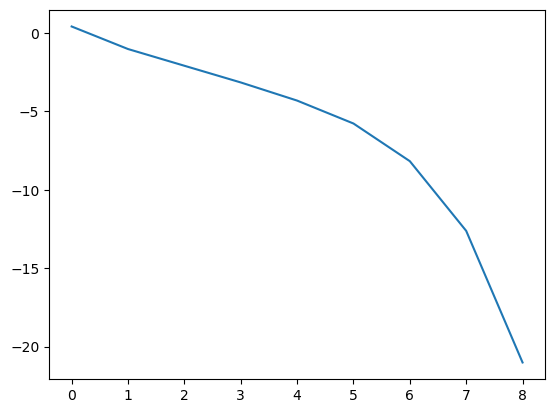

In [11]:
plt.figure()
plt.plot(grad_norm_log)
plt.show()

### *Question 3.4*

In this part, we will run newton algorithm with taking into account as initial point ${(\omega_0^0,w^0)=e}$ with e a vector of ones

In [43]:
rho = 1.0 / X.shape[0]
epsilon = 10e-10
w0 = 1
w=np.ones(X.shape[1])

time1 = time.time()

f,wt,c,grad_norm_log = newton(X,y,w,w0,rho,epsilon)
time2 = time.time()

print("Number of iterations: ",c)
print("Time used : ", (time2 - time1))
print('f = ', f)

Number of iterations:  1
Time used :  1.8653411865234375
f =  inf


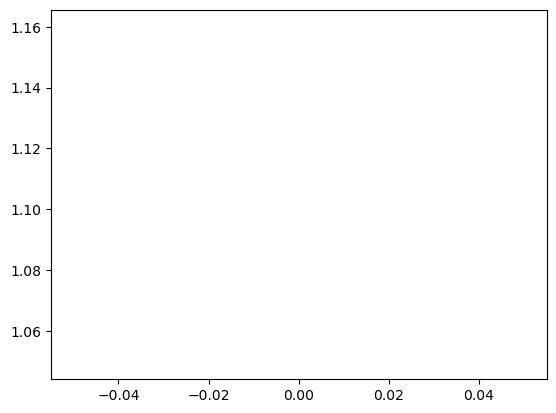

In [44]:
plt.figure()
plt.plot(grad_norm_log)
plt.show()

We observe an overflow in the gradient and function value, because the Newton method can't sovle this problem, the value is too big, and the algorithme will diverge. We need a good initialisation for wt=(w0,w) to obtain 

### *Question 3.5*

Armijo's line search with a  Given $a ∈ [0;1]$, $b > 0$ and $β ∈ [0;1]$, will help us determine $l$ such that:

$${f(x_k-ba^l.∇f(x_k))≤f(x_k)+<\nabla f(x_k),-ba^l.∇f(x_k)>
+ \frac{1}{2ba^l}.\|ba^l.∇f(x_k)\|^2}$$

In [14]:
def armijolinesearch(w,f,g,lap,a,b):
    l=1.0
    beta=0.5
    gamma=b*(a**l)
    while (f(w-gamma*lap) > f(w)-beta*gamma*np.sum(g*lap)): #inequality of armijo
        l += 1.0
        gamma=b*(a**l) #knowing b and a, we will be able to find l

    return gamma

In [15]:
from scipy import ndimage

def newton_armijo(comp,w,w0,x,y,rho,eps,numMax):
    
    f,g,h=comp(w,w0,x,y,rho)
    a=0.9
    l=0.0
    gamma=1.0
    k=0
    
    gradnorm = [np.linalg.norm(g[1:])]
    
    lap = ndimage.laplace(np.append(w0,w))  #Laplacien 

    while(((np.linalg.norm(g[1:] > eps)) and (k < numMax))):
        
        gamma= armijolinesearch(np.append(w0,w),func,g,lap,a,2*gamma)
        l =np.append(w0,w)-lap*gamma
        
        w0=l[0]
        w=l[1:]
        
        f,g,h=comp(w,w0,x,y,rho)
        
        lap= ndimage.laplace(np.append(w0,w))
        
        gradnorm.append(np.linalg.norm(g[1:]))
        k +=1  #number of iterations 
        
    return f, np.append(w0, w), gradnorm, k

In [16]:
#Instanciation
rho = 1.0 / X.shape[0]
epsilon = 10e-10
w0 = 0.3
w = 0.3 * np.ones(X.shape[1])

# with linear search
time1 = time.time()
val, wna, gradnorm, k = newton_armijo(Computing,w,w0,X,y,rho,epsilon,30)
time2 = time.time()

print("The value minimal of the objective function :",val)
print("The variable minimal of the objective function : \n",wna)
print("Times of iterations: ", k)
print("Time used : ", (time2 - time1))

The value minimal of the objective function : 17.579562972378284
The variable minimal of the objective function : 
 [0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3

30 iterations to converge !

###  **4. Regularization for a sparse model**

#### *Question 4.1*

We can't use Newton's method to resolve the problem because the regularization term is not differentiable: $||.||_1$ 


We have the function:
$$\min_{w0\in \mathbb{R},w\in \mathbb{R}^{p+1}}\dfrac {1} {n}\sum _{i=1}^{n}\log \left( 1+e^{-y_{i}\left( {x_{i}}^{T}w+w_{0}\right) }\right) + \rho \left\| w\right\| _{1}\displaystyle $$  
Newton's method assumes that the function is 3-differentiable.

### *Question 4.2*

$ F_2 $ is decomposed in the form $F_2 = f_2 + g_2$ with 


$$f_{2}  (\omega_0, \omega)= \dfrac {1} {n}\sum _{i=1}^{n}\log \left( 1+e^{-y_{i}\left( {x_{i}}^{T}w+w_{0}\right) }\right) $$
 and  $$g_{2}  (\omega)= \rho \left \| \omega \right \|_{1} $$ 

$[prox_{\gamma g_2} (x)]_i=
\begin{cases}
x_i + \gamma\rho & if & x_i < -\gamma\rho\\
0              & if & |x_i| < \gamma\rho\\
x_i - \gamma\rho & if & x_i > \gamma\rho 
\end{cases}$


for the gradient we have :

$\triangledown f_{2} (\omega_0, \omega) = \frac{1}{n}\sum_{i=1}^{n}\frac{-y_{i}}{1+exp(y_{i}(x_{i}^{T}\omega +\omega _{0}))}\begin{pmatrix}
1\\x_{i} \end{pmatrix}$


### *Question 4.3*

In [17]:
def f2(w,X,y):
    
    xw = [np.dot(X[i], w) for i in range(n)]
    summ = [np.log(1+np.exp(-y[i]*xw[i])) for i in range(n)]
    return 1.0/n*sum(summ)

def gradf2(w,X,y):
    
    xw = [np.dot(X[i], w) for i in range(n)]
    summ = [-y[i]/(1+np.exp(y[i]*xw[i]))*X[i].T for i in range(n)]
    return np.ravel(1.0/n * sum(summ))

def g2(w,rho):
    
    return rho * np.linalg.norm(w,ord=1)

def F2(w,X,y,rho):
    
    return f2(w,X,y) + g2(w,rho)

def obfunc2(w, X, y, rho):
    
    return f2(w,X,y), gradf2(w,X,y),F2(w,X,y,rho)

In [18]:
def funcsoft(w,rho):
    
    sw = np.zeros_like(w)
    sw[w > rho] = w[w > rho] - rho
    sw[w < -rho] = w[w < -rho] + rho
    sw[0] = w[0]
    return sw

def proximal_algo(g, w0, X, y, rho, tolerance = 1e-10, max_iter = 1e2):
    
    a = 0.5
    b=1
    1
    val, grad, valF= g(w0, X, y, rho)
    diff = tolerance + 1
    k = 0
    
    while((diff > tolerance) and (k <= max_iter)):
        
        gamma = b
        wk = funcsoft(w0 - gamma*grad, gamma*rho)
        valk, gradk, valFk = g(wk, X, y, rho)
        while(valk > val+np.sum(grad*(wk - w0)) + np.sum((w0 - wk)**2)/(2*gamma)):
            gamma = gamma * a
            wk = funcsoft(w0 - gamma*grad, gamma*rho)
            valk, gradk, valFk = g(wk, X, y, rho)
        diff = valF - valFk
        w0 = wk
        val, grad, valF = g(w0, X, y, rho)
        b = 2 * gamma
        k = k + 1    
    return valF, w0, k

In [19]:
import time
import numpy as np

rho = 0.02
time1 = time.time()
n,p = X.shape
X1 = np.column_stack((np.ones(n), X))
w = 0.5*np.ones_like(X1[0])

val, sol_l1, k = proximal_algo(obfunc2, w, X1, y, rho, 1e-10)
time2 = time.time()

print("{} Iterations done in {} seconds.".format(k,time2-time1))
print("Results: ")
print(val)
print(sol_l1)

91 Iterations done in 0.5087664127349854 seconds.
Results: 
0.4260318315980992
[ 1.81478190e-03  0.00000000e+00 -1.47861193e-01 -8.92797203e-02
  0.00000000e+00  0.00000000e+00  5.67577087e-02  1.76749734e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.29095242e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.23910162e-02  0.00000000e+00  2.25283058e-02  0.00000000e+00
  2.40875686e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.00778019e-02
  2.63154062e-01  0.00000000e+00 -2.84616005e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.48501236e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.04841019e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.0000000

### **6. Comparison**

#### *Question 6.1*

Despite both being convex functions, only the first is differentiable, while the second isn't.

Whenever the initial values are within Newton's convergence zone, the method converges quickly.

##### *Question 6.2*
As you can see in the first representation, predictor values vary depending upon the values taken by $\omega$ and $\omega_0$. Alternatively, the predictors in the second representation are null.